# Credit Card fraud

Ashere Jeswin - 21PD02

Harini.K.V - 21PD10

V.K.Deeksha - 21PD37

### Context

It is important that credit card companies are able to recognize fraudulent credit card transactions so that customers are not charged for items that they did not purchase.

### Content

The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.



In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
from IPython.display import Image

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from collections import Counter

In [ ]:
try:
    raw_df = pd.read_csv('../input/creditcardfraud/creditcard.csv')
except:
    raw_df = pd.read_csv('creditcard.csv')

##  Data imbalance check

In [ ]:
labels=["Genuine","Fraud"]

fraud_or_not = raw_df["Class"].value_counts().tolist()
values = [fraud_or_not[0], fraud_or_not[1]]

fig = px.pie(values=raw_df['Class'].value_counts(), names=labels , width=700, height=400, color_discrete_sequence=["skyblue","black"]
             ,title="Fraud vs Genuine transactions")
fig.show()

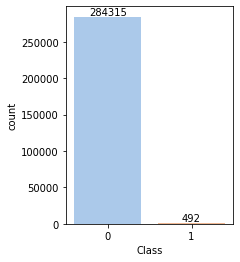

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=raw_df,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

In [ ]:
print('Genuine:', round(raw_df['Class'].value_counts()[0]/len(raw_df) * 100,2), '% of the dataset')
print('Frauds:', round(raw_df['Class'].value_counts()[1]/len(raw_df) * 100,2), '% of the dataset')

Genuine: 99.83 % of the dataset
Frauds: 0.17 % of the dataset


![imbalanced.png](attachment:05aaa524-09eb-4ed8-a107-bb43519b093d.png)

##  99.8% Accuracy score before implementing any model

Don't use accuracy score as a metric with imbalanced datasets - it will be usually high and misleading. In this dataset:

* we have **99,8%** of Genuine transactions and only **0,173%** (492) of fraud transactions;

* whis means that a blind guess (bet on Genuine) would give us accuracy of **99,8%**.

#  Data pre-processing

##  Dropping duplicated values

In [ ]:
df = raw_df.copy()

df.drop_duplicates(inplace=True)
print("Duplicated values dropped succesfully")

In [ ]:
df = df.drop('Time', axis=1)

###  Checking for outliers

In [ ]:
numeric_columns = (list(df.loc[:, 'V1':'Amount']))

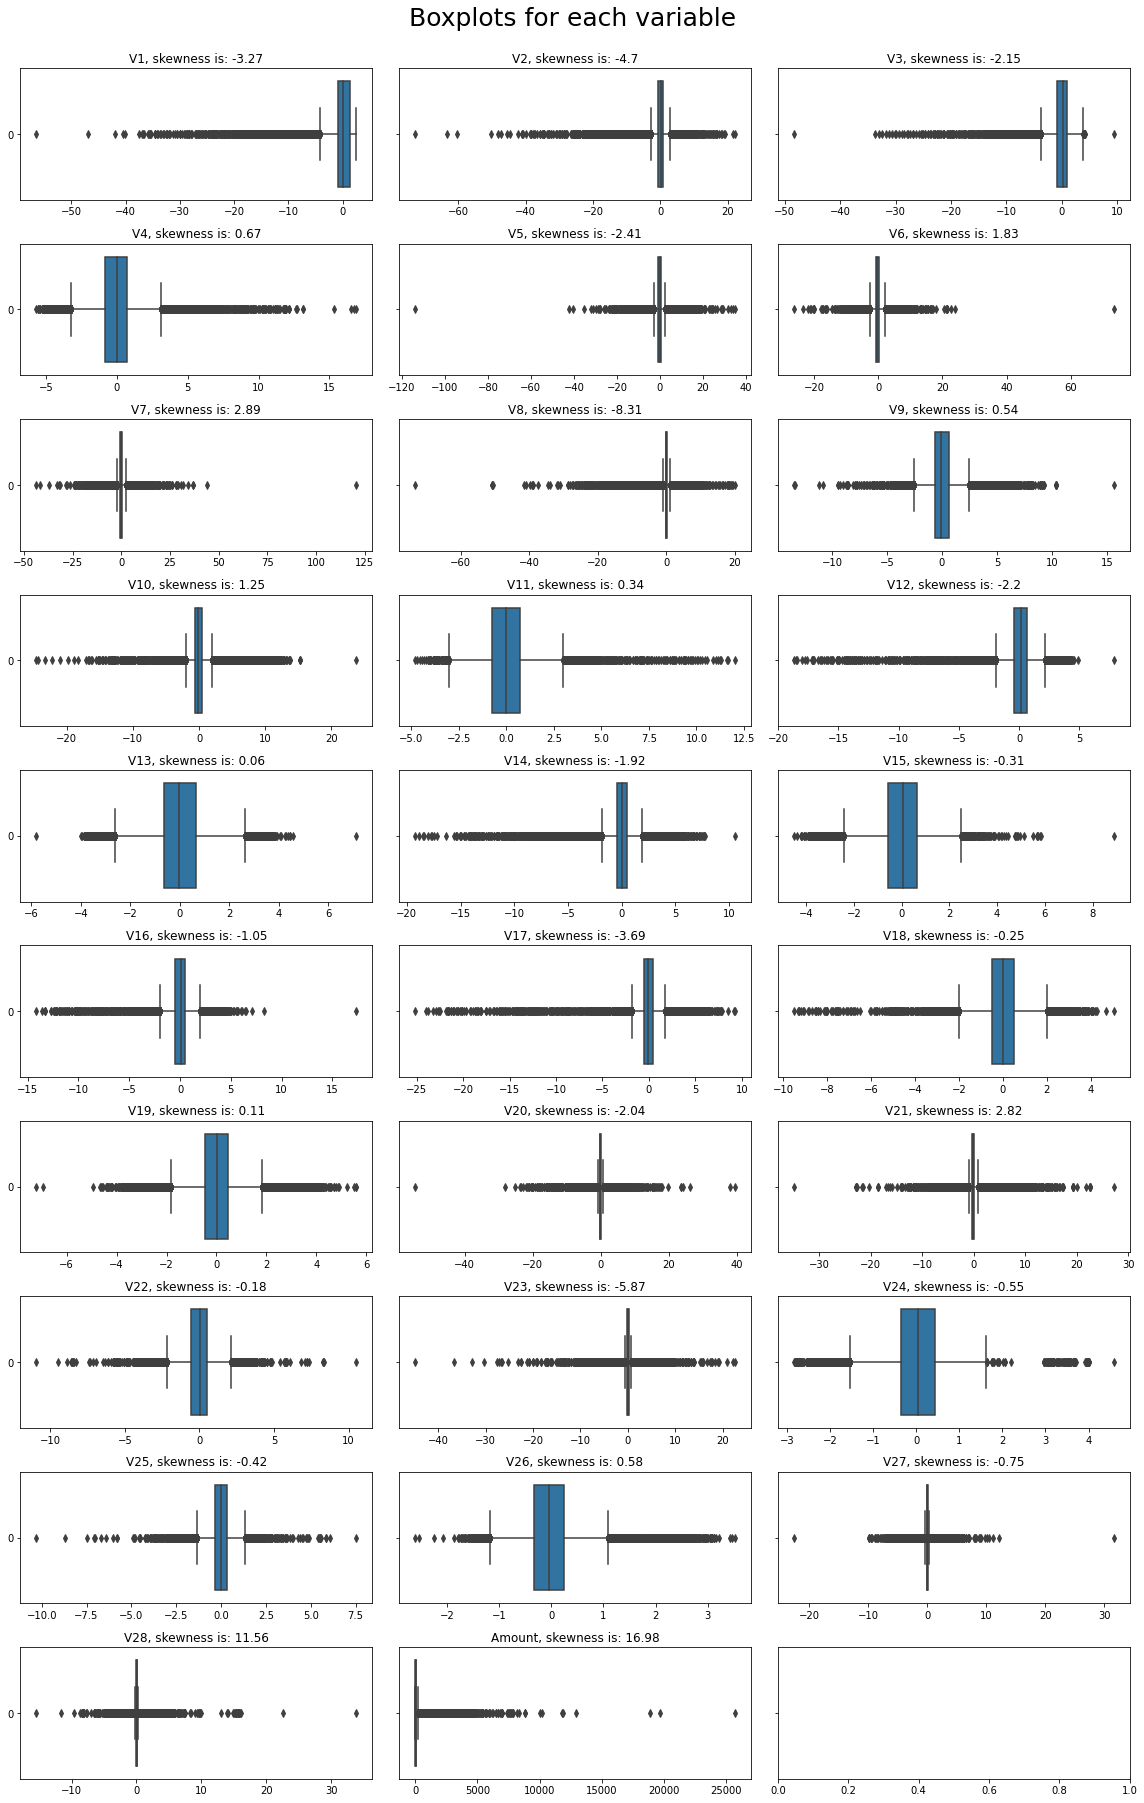

In [ ]:
# checking boxplots
def boxplots_custom(dataset, columns_list, rows, cols, suptitle):
    fig, axs = plt.subplots(rows, cols, sharey=True, figsize=(16,25))
    fig.suptitle(suptitle,y=1, size=25)
    axs = axs.flatten()
    for i, data in enumerate(columns_list):
        sns.boxplot(data=dataset[data], orient='h', ax=axs[i])
        axs[i].set_title(data + ', skewness is: '+str(round(dataset[data].skew(axis = 0, skipna = True),2)))
        
boxplots_custom(dataset=df, columns_list=numeric_columns, rows=10, cols=3, suptitle='Boxplots for each variable')
plt.tight_layout()

###  Inter Quartile Range (IQR)



Inter Quartile Range (IQR) is one of the most extensively used procedure for outlier detection and removal.

Procedure:

1. Find the first quartile, Q1.
2. Find the third quartile, Q3.
3. Calculate the IQR. IQR = Q3-Q1.
4. Define the normal data range with lower limit as Q1–1.5 IQR and upper limit as Q3+1.5 IQR.



In [ ]:
def IQR_method (df,n,features):
    """
    Takes a dataframe and returns an index list corresponding to the observations 
    containing more than n outliers according to the Tukey IQR method.
    """
    outlier_list = []
    
    for column in features:
        # 1st quartile (25%)
        Q1 = np.percentile(df[column], 25)
        # 3rd quartile (75%)
        Q3 = np.percentile(df[column],75)
        # Interquartile range (IQR)
        IQR = Q3 - Q1
        # outlier step
        outlier_step = 1.5 * IQR
        # Determining a list of indices of outliers
        outlier_list_column = df[(df[column] < Q1 - outlier_step) | (df[column] > Q3 + outlier_step )].index
        # appending the list of outliers 
        outlier_list.extend(outlier_list_column)
        
    # selecting observations containing more than x outliers
    outlier_list = Counter(outlier_list)        
    multiple_outliers = list( k for k, v in outlier_list.items() if v > n )
    
    # Calculate the number of records below and above lower and above bound value respectively
    out1 = df[df[column] < Q1 - outlier_step]
    out2 = df[df[column] > Q3 + outlier_step]
    
    print('Total number of deleted outliers is:', out1.shape[0]+out2.shape[0])
    
    return multiple_outliers

In [ ]:
# detecting outliers
Outliers_IQR = IQR_method(df,1,numeric_columns)

# dropping outliers
df_out = df.drop(Outliers_IQR, axis = 0).reset_index(drop=True)

Total number of deleted outliers is: 31685


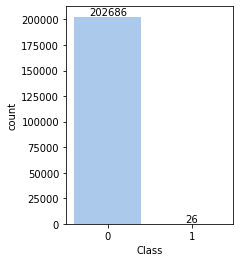

In [ ]:
plt.figure(figsize=(3,4))
ax = sns.countplot(x='Class',data=df_out,palette="pastel")
for i in ax.containers:
    ax.bar_label(i,)

We stayed with only **26** fraud transactions in entire data frame!

#### We deleted almost all fraud transactions from a dataframe!

We have a few options here, but for that study we will just come back to the stage just before dropping outliers.



## Stratified splitting

Stratified splitting means that when you generate a training / validation dataset split, it will attempt to keep the same percentages of classes in each split.

These dataset divisions are usually generated randomly according to a target variable. However, when doing so, the proportions of the target variable among the different splits can differ, especially in the case of small datasets.

In [ ]:
X = df.drop('Class', axis=1)
y = df['Class']

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.3, random_state = 42)

#  Feature scaling

In [ ]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [ ]:
col_names = ['Amount']
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

## Cross-validation

The best model is not the one that gives accurate predictions on the training data, but the one which gives good predictions on the new data and avoids overfitting and underfitting.

Cross-validation is a resampling procedure used to evaluate machine learning models on a limited data sample. The procedure has a single parameter called k that refers to the number of groups that a given data sample is to be split into. As such, the procedure is often called k-fold cross-validation.

The purpose of cross–validation is to test the ability of a machine learning model to predict new data. 

![crossval.png](attachment:e8959750-2feb-4158-831f-b695b1cda15c.png)

##  Stratified K-Fold CV (Cross-Validation)

Stratification is used when the datasets contain unbalanced classes. Therefore if we cross-validate with a normal technique it may produce subsamples that have a varying distribution of classes. Some unbalanced samples may produce exceptionally high scores leading to a high cross-validation score overall, which is undesirable. Therefore we create stratified subsamples that preserve the class frequencies in the individual folds to ensure that we are able to get a clear picture of the model performance.

##  Oversample/undersample and Cross Validation

![download.png](attachment:8b78dcc3-9609-4fa1-94bd-7a6d10629624.png)![underover.png](attachment:45e3d81b-b4b2-43d1-8133-9cbf0337ee92.png)

If you want to undersample or oversample your data you shouldn't do it before cross validating because you will be directly influencing the validation set before implementing cross-validation causing a "data leakage" problem.

Exactly like we should do feature selection inside the cross validation loop, we should also oversample inside the loop.

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

#We are going to ensure that we have the same splits of the data every time. 
#We can ensure this by creating a KFold object, kf, and passing cv=kf instead of the more common cv=5.

kf = StratifiedKFold(n_splits=5, shuffle=False)

Random forest is a machine learning algorithm used for classification and regression tasks. It is an ensemble learning method that combines multiple decision trees to create a more accurate and stable model.

In a random forest model, a set of decision trees is built on randomly selected subsets of the training data, and the results are aggregated to produce the final output. Each decision tree is trained on a random subset of the features in the dataset, which helps to reduce overfitting and improve generalization.

In [ ]:
rf = RandomForestClassifier(n_estimators=100, random_state=13)
#cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')

#  Metrics for imbalanced data

## Choosing metrics

The most common metrics to use for imbalanced datasets are:

* F1 score
* Precision
* Recall
* AUC score (AUC ROC)
* Average precision score (AP)
* G-Mean

It is good practice to track multiple metrics when developing a machine learning model as each highlights different aspects of model performance. 

![metrics.png](attachment:956255a6-64a8-4676-8191-0c678ec02483.png)

##  Optimising for Recall

Recall: **The ability of a model to find all the relevant cases within a data set**. The number of true positives divided by the number of true positives plus the number of false negatives.

In the case of credit card fraud detection, we want to avoid false negatives as much as possible. Fraud transactions cost us a lot and thus we want to take appropriate measures to prevent them. A false negative case means that a fraud-positive transaction is assessed to genuine transaction, which is detrimental. In this use case, false positives (a genuine transaction as fraud-positive) are not as important as preventing a fraud.

In [ ]:
score = cross_val_score(rf, X_train, y_train, cv=kf, scoring='recall')
print("Cross Validation Recall scores are: {}".format(score))
print("Average Cross Validation Recall score: {}".format(score.mean()))

Cross Validation Recall scores are: [0.8030303  0.74242424 0.76119403 0.87878788 0.65151515]
Average Cross Validation Recall score: 0.7673903211216644


## When is Precision more important over Recall?

Precision is more important than Recall when you would like to have less False Positives in trade off to have more False Negatives. Meaning, getting a False Positive is very costly, and a False Negative is not as much.

![image.png](attachment:c2e0e361-c78b-42e4-b706-0a90cd261d7a.png)![image.png](attachment:fdc7709b-e364-4030-abc4-b9a1a96c5c15.png)![download.png](attachment:6b03b2c6-0160-4ce5-93eb-df87fbeb2b09.png)

##  Hyperparameter Tuning Using GridSearchCV

Hyperparameter tuning is the process of tuning the parameters present as the tuples while we build machine learning models. These parameters are defined by us. Machine learning algorithms never learn these parameters. These can be tuned in different step.

GridSearchCV is a technique for finding the optimal hyperparameter values from a given set of parameters in a grid. It's essentially a cross-validation technique. The model as well as the parameters must be entered. After extracting the best parameter values, predictions are made.

The “best” parameters that GridSearchCV identifies are technically the best that could be produced, but only by the parameters that you included in your parameter grid.

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10, 12],
    'random_state': [13]
}

grid_rf = GridSearchCV(rf, param_grid=params, cv=kf, 
                          scoring='recall').fit(X_train, y_train)

In [ ]:
print('Best parameters:', grid_rf.best_params_)
print('Best score:', grid_rf.best_score_)

We have about 77% Recall on one of our models before oversampling. Let's check the test set scores.

In [ ]:
y_pred = grid_rf.predict(X_test)

In [ ]:
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, accuracy_score
cm = confusion_matrix(y_test, y_pred)

rf_Recall = recall_score(y_test, y_pred)
rf_Precision = precision_score(y_test, y_pred)
rf_f1 = f1_score(y_test, y_pred)
rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

F1 score = 2 * (precision * recall) / (precision + recall)

In [ ]:
ndf = [(rf_Recall, rf_Precision, rf_f1, rf_accuracy)]

rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
rf_score.insert(0, 'Random Forest with', 'No Under/Oversampling')
rf_score

The result Recall score for a test set is 77%. We will try to beat that score.

# Random Resampling Imbalanced Datasets

Resampling involves creating a new transformed version of the training dataset in which the selected examples have a different class distribution.

There are two main approaches to random resampling for imbalanced classification; they are oversampling and undersampling.

* Random Oversampling: Randomly duplicate examples in the minority class.
* Random Undersampling: Randomly delete examples in the majority class.

They are referred to as “naive resampling” methods because they assume nothing about the data and no heuristics are used. This makes them simple to implement and fast to execute, which is **desirable for very large and complex datasets**.

#### Important
Change to the class distribution should be only applied to the **training dataset**. The intent is to influence the fit of the models. The resampling is not applied to the test or holdout dataset used to evaluate the performance of a model.

## Random Oversampling

Oversampling involves increasing the number of instances in the minority class by creating synthetic data points. This can be done using techniques such as duplication, interpolation, or the creation of new instances using generative models. Oversampling can help improve the performance of machine learning models by providing more representative data for the minority class.

The random oversampling may increase the likelihood of occurring overfitting, since it makes exact copies of the minority class examples. Let's say every data point from the minority class is copied 6 times before making the splits. If we did a 3-fold validation, each fold has (on average) 2 copies of each point! In this way a classifier might construct rules that are apparently accurate, but actually cover one replicated example.

In [ ]:
from imblearn.over_sampling import RandomOverSampler
# define oversampling strategy
ros = RandomOverSampler(random_state=42)

In [ ]:
# fit and apply the transform
X_over, y_over = ros.fit_resample(X_train, y_train)

In [ ]:
print('Genuine:', y_over.value_counts()[0], '/', round(y_over.value_counts()[0]/len(y_over) * 100,2), '% of the dataset')
print('Frauds:', y_over.value_counts()[1], '/',round(y_over.value_counts()[1]/len(y_over) * 100,2), '% of the dataset')

###  Imbalanced-Learn Pipeline

The purpose of the pipeline is to assemble several steps that can be cross-validated together while setting different parameters.

During the cross-validation process we should split into training and validation segments. Then, on each segment, we should:

1. Oversample the minority class.
2. Train the classifier on the training segment.
3. Validate the classifier on the remaining segment.

Pipeline is a great way to do this in a smart way.

The imblearn package contains a lot of different samplers for oversampling and undersampling. These samplers can not be placed in a standard sklearn pipeline.

To allow for using a pipeline with these samplers, the imblearn package also implements an extended pipeline which has a bunch of extra functions to do with transforming and sampling.

###  Training model

In [ ]:
from imblearn.pipeline import Pipeline, make_pipeline

random_overs_pipeline = make_pipeline(RandomOverSampler(random_state=42), 
                              RandomForestClassifier(n_estimators=100, random_state=13))
#cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)

In [ ]:
score2 = cross_val_score(random_overs_pipeline, X_train, y_train, scoring='recall', cv=kf)
print("Cross Validation Recall Scores are: {}".format(score2))
print("Average Cross Validation Recall score: {}".format(score2.mean()))

###  GridSearchCV

In [ ]:
new_params = {'randomforestclassifier__' + key: params[key] for key in params}
grid_over_rf = GridSearchCV(random_overs_pipeline, param_grid=new_params, cv=kf, scoring='recall',
                        return_train_score=True)
grid_over_rf.fit(X_train, y_train)

In [ ]:
print('Best parameters:', grid_over_rf.best_params_)
print('Best score:', grid_over_rf.best_score_)

###  Confusion matrix and scores

In [ ]:
y_pred = grid_over_rf.best_estimator_.named_steps['randomforestclassifier'].predict(X_test)

In [ ]:
cm = confusion_matrix(y_test, y_pred)

over_rf_Recall = recall_score(y_test, y_pred)
over_rf_Precision = precision_score(y_test, y_pred)
over_rf_f1 = f1_score(y_test, y_pred)
over_rf_accuracy = accuracy_score(y_test, y_pred)

print(cm)

In [ ]:
ndf = [(over_rf_Recall, over_rf_Precision, over_rf_f1, over_rf_accuracy)]

over_rf_score = pd.DataFrame(data = ndf, columns=['Recall','Precision','F1 Score', 'Accuracy'])
over_rf_score.insert(0, 'Random Forest with', 'Random Oversampling')
over_rf_score

In [ ]:
predictions = pd.concat([rf_score, over_rf_score, smote_rf_score, SMOTETomek_rf_score, grid_rfb_score], ignore_index=True, sort=False)
predictions.sort_values(by=['Recall'], ascending=False)

#  Other Metrics

##  AUC-ROC Curve

AUC (Area Under The Curve) ROC (Receiver Operating Characteristics) curve.

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

The ROC curve is plotted with TPR against the FPR where TPR is on the y-axis and FPR is on the x-axis.

An excellent model has AUC near to the 1 which means it has a good measure of separability. A poor model has an AUC near 0 which means it has the worst measure of separability.

* When AUC is 0.7, it means there is a 70% chance that the model will be able to distinguish between positive class and negative class.
* When AUC is approximately 0.5, the model has no discrimination capacity to distinguish between positive class and negative class.
* When AUC is approximately 0, the model is predicting a negative class as a positive class and vice versa.

In [ ]:
from sklearn.metrics import roc_auc_score
ROCAUCscore = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Curve for Random Forest with Class weights: {ROCAUCscore:.4f}")

In [ ]:
y_proba = grid_rfb.predict_proba(X_test)

from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
def plot_auc_roc_curve(y_test, y_pred):
    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()
    roc_display.figure_.set_size_inches(5,5)
    plt.plot([0, 1], [0, 1], color = 'g')
# Plots the ROC curve using the sklearn methods - Good plot
plot_auc_roc_curve(y_test, y_proba[:, 1])
# Plots the ROC curve using the sklearn methods - Bad plot
#plot_sklearn_roc_curve(y_test, y_pred)

## Precision-Recall Curve (PR curve)

The precision-recall curve shows the tradeoff between precision and recalls for different thresholds.

In [ ]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay

display = PrecisionRecallDisplay.from_estimator(
    grid_rfb, X_test, y_test, name="Average precision")
_ = display.ax_.set_title("Random Forest with Class weights")

We can clearly see the point where we have to start trading a lot of Precision for better Recall score!

Average precision (AP) summarizes such a plot as the weighted mean of precisions achieved at each threshold, with the increase in recall from the previous threshold.